In [1]:
import time
import numpy as np
import tensorflow as tf
import re
from collections import Counter
from time import sleep
import json
import random

In [2]:
with open('data/ner_train.json') as json_data:
    d = json.load(json_data)

text=[]
l=0

for i in d:
    for j in i:
        for k in j:
            text.append(k)

tt = []
for i in range(len(text)):
    if(text[i]!=''):
        tt.append(text[i])

text = tt

word_counts = Counter(text)

word_counts.most_common()

[('O', 2412444),
 ('LOCATION', 76720),
 ('ORGANIZATION', 61678),
 ('PERSON', 58985)]

In [3]:
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: A tuple of dicts.  The first dict....
    """
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)


def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [4]:
words = text

print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

# vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

Total words: 2609827
Unique words: 4


In [5]:
def get_train_word():
    threshold = random.uniform(0.6, 0.9)
    word_counts = Counter(int_words)
    total_count = len(int_words)
    freqs = {word: count/total_count for word, count in word_counts.items()}
    p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
    train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]
    return train_words, threshold

In [6]:
batch_size = 1000
window_size = 2
n_vocab = len(int_to_vocab)
n_embedding =  25

In [7]:
with tf.device('/device:CPU:0'):

    train_graph = tf.Graph()
    with train_graph.as_default():
        inputs = tf.placeholder(tf.int32, [None], name='inputs')
    #     labels = tf.placeholder(tf.int32, [None, None], name='labels')
        labels = tf.placeholder(tf.int32, [None, None], name='labels')
        
        embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
        embed = tf.nn.embedding_lookup(embedding, inputs) # use tf.nn.embedding_lookup to get the hidden layer output
        
        softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding))) # create softmax weight matrix here
        softmax_b = tf.Variable(tf.zeros(n_vocab), name="softmax_bias") # create softmax biases here
        
        logits = tf.matmul(embed, tf.transpose(softmax_w)) + softmax_b
        labels_one_hot = tf.one_hot(labels, n_vocab)

        loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels_one_hot, logits=logits)
        cost = tf.reduce_mean(loss)
        
        global_step = tf.Variable(0, trainable=False, name="global_step")

        optimizer = tf.train.AdamOptimizer().minimize(cost, global_step=global_step)
        
         ## From Thushan Ganegedara's implementation
        valid_size = 3 # Random set of words to evaluate similarity on.
        valid_window = n_vocab
        # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
        valid_examples = np.array(random.sample(range(valid_window), valid_size))
#         valid_examples = np.append(valid_examples, 
#                                    random.sample(range(1000,1000+valid_window), valid_size//2))

        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

        # We use the cosine distance:
        norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
        normalized_embedding = embedding / norm
        valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
        similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [8]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints/ner

mkdir: cannot create directory ‘checkpoints/ner’: File exists


In [9]:
epochs = 50

In [10]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())
    
#     saver.restore(sess, tf.train.latest_checkpoint('checkpoints/ner'))
#     embed_mat = sess.run(embedding)
    
    for e in range(1, epochs+1):
        train_words, threshold = get_train_word()
        print("Epoch {}/{}".format(e, epochs), "Threshold: {}".format(threshold), "Length of Training words: {}".format(len(train_words)))
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            global_steps, train_loss, _ = sess.run([global_step, cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100== 0: 
                end = time.time()
                print("Global Step: {}".format(global_steps), "Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
                        
            iteration += 1
    save_path = saver.save(sess, "checkpoints/ner/ner.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/50 Threshold: 0.7253311070144872 Length of Training words: 2334060
Global Step: 100 Epoch 1/50 Iteration: 100 Avg. Training loss: 1.0828 0.0071 sec/batch
Global Step: 200 Epoch 1/50 Iteration: 200 Avg. Training loss: 0.5837 0.0073 sec/batch
Global Step: 300 Epoch 1/50 Iteration: 300 Avg. Training loss: 0.5848 0.0072 sec/batch
Global Step: 400 Epoch 1/50 Iteration: 400 Avg. Training loss: 0.5640 0.0072 sec/batch
Global Step: 500 Epoch 1/50 Iteration: 500 Avg. Training loss: 0.5213 0.0071 sec/batch
Global Step: 600 Epoch 1/50 Iteration: 600 Avg. Training loss: 0.5166 0.0069 sec/batch
Global Step: 700 Epoch 1/50 Iteration: 700 Avg. Training loss: 0.4854 0.0070 sec/batch
Global Step: 800 Epoch 1/50 Iteration: 800 Avg. Training loss: 0.5632 0.0069 sec/batch
Global Step: 900 Epoch 1/50 Iteration: 900 Avg. Training loss: 0.5081 0.0067 sec/batch
Global Step: 1000 Epoch 1/50 Iteration: 1000 Avg. Training loss: 0.5941 0.0072 sec/batch
Global Step: 1100 Epoch 1/50 Iteration: 1100 Avg. Tra

Global Step: 9000 Epoch 4/50 Iteration: 9000 Avg. Training loss: 0.4530 0.0079 sec/batch
Global Step: 9100 Epoch 4/50 Iteration: 9100 Avg. Training loss: 0.4890 0.0080 sec/batch
Global Step: 9200 Epoch 4/50 Iteration: 9200 Avg. Training loss: 0.5549 0.0065 sec/batch
Global Step: 9300 Epoch 4/50 Iteration: 9300 Avg. Training loss: 0.4613 0.0074 sec/batch
Epoch 5/50 Threshold: 0.704454348766629 Length of Training words: 2303960
Global Step: 9400 Epoch 5/50 Iteration: 9400 Avg. Training loss: 0.5777 0.0030 sec/batch
Global Step: 9500 Epoch 5/50 Iteration: 9500 Avg. Training loss: 0.6077 0.0066 sec/batch
Global Step: 9600 Epoch 5/50 Iteration: 9600 Avg. Training loss: 0.5087 0.0074 sec/batch
Global Step: 9700 Epoch 5/50 Iteration: 9700 Avg. Training loss: 0.5940 0.0073 sec/batch
Global Step: 9800 Epoch 5/50 Iteration: 9800 Avg. Training loss: 0.5221 0.0076 sec/batch
Global Step: 9900 Epoch 5/50 Iteration: 9900 Avg. Training loss: 0.5127 0.0063 sec/batch
Global Step: 10000 Epoch 5/50 Iterat

Global Step: 17700 Epoch 8/50 Iteration: 17700 Avg. Training loss: 0.5470 0.0077 sec/batch
Global Step: 17800 Epoch 8/50 Iteration: 17800 Avg. Training loss: 0.5310 0.0069 sec/batch
Global Step: 17900 Epoch 8/50 Iteration: 17900 Avg. Training loss: 0.5200 0.0073 sec/batch
Global Step: 18000 Epoch 8/50 Iteration: 18000 Avg. Training loss: 0.5511 0.0073 sec/batch
Global Step: 18100 Epoch 8/50 Iteration: 18100 Avg. Training loss: 0.5150 0.0066 sec/batch
Global Step: 18200 Epoch 8/50 Iteration: 18200 Avg. Training loss: 0.5415 0.0064 sec/batch
Global Step: 18300 Epoch 8/50 Iteration: 18300 Avg. Training loss: 0.5408 0.0086 sec/batch
Global Step: 18400 Epoch 8/50 Iteration: 18400 Avg. Training loss: 0.4861 0.0088 sec/batch
Global Step: 18500 Epoch 8/50 Iteration: 18500 Avg. Training loss: 0.5898 0.0082 sec/batch
Global Step: 18600 Epoch 8/50 Iteration: 18600 Avg. Training loss: 0.4911 0.0083 sec/batch
Epoch 9/50 Threshold: 0.7716715552212245 Length of Training words: 2401683
Global Step: 18

Global Step: 26400 Epoch 12/50 Iteration: 26400 Avg. Training loss: 0.4929 0.0066 sec/batch
Global Step: 26500 Epoch 12/50 Iteration: 26500 Avg. Training loss: 0.4912 0.0066 sec/batch
Global Step: 26600 Epoch 12/50 Iteration: 26600 Avg. Training loss: 0.5161 0.0065 sec/batch
Global Step: 26700 Epoch 12/50 Iteration: 26700 Avg. Training loss: 0.5067 0.0070 sec/batch
Global Step: 26800 Epoch 12/50 Iteration: 26800 Avg. Training loss: 0.5850 0.0065 sec/batch
Global Step: 26900 Epoch 12/50 Iteration: 26900 Avg. Training loss: 0.5679 0.0065 sec/batch
Global Step: 27000 Epoch 12/50 Iteration: 27000 Avg. Training loss: 0.5550 0.0065 sec/batch
Global Step: 27100 Epoch 12/50 Iteration: 27100 Avg. Training loss: 0.5714 0.0065 sec/batch
Global Step: 27200 Epoch 12/50 Iteration: 27200 Avg. Training loss: 0.5088 0.0069 sec/batch
Global Step: 27300 Epoch 12/50 Iteration: 27300 Avg. Training loss: 0.5100 0.0067 sec/batch
Global Step: 27400 Epoch 12/50 Iteration: 27400 Avg. Training loss: 0.5294 0.006

Global Step: 35100 Epoch 15/50 Iteration: 35100 Avg. Training loss: 0.4474 0.0068 sec/batch
Global Step: 35200 Epoch 15/50 Iteration: 35200 Avg. Training loss: 0.4796 0.0067 sec/batch
Global Step: 35300 Epoch 15/50 Iteration: 35300 Avg. Training loss: 0.5526 0.0065 sec/batch
Global Step: 35400 Epoch 15/50 Iteration: 35400 Avg. Training loss: 0.4471 0.0065 sec/batch
Epoch 16/50 Threshold: 0.7760363353058254 Length of Training words: 2407919
Global Step: 35500 Epoch 16/50 Iteration: 35500 Avg. Training loss: 0.5610 0.0014 sec/batch
Global Step: 35600 Epoch 16/50 Iteration: 35600 Avg. Training loss: 0.5989 0.0067 sec/batch
Global Step: 35700 Epoch 16/50 Iteration: 35700 Avg. Training loss: 0.5055 0.0065 sec/batch
Global Step: 35800 Epoch 16/50 Iteration: 35800 Avg. Training loss: 0.5647 0.0066 sec/batch
Global Step: 35900 Epoch 16/50 Iteration: 35900 Avg. Training loss: 0.5518 0.0066 sec/batch
Global Step: 36000 Epoch 16/50 Iteration: 36000 Avg. Training loss: 0.4939 0.0073 sec/batch
Glob

Global Step: 43700 Epoch 19/50 Iteration: 43700 Avg. Training loss: 0.5755 0.0078 sec/batch
Global Step: 43800 Epoch 19/50 Iteration: 43800 Avg. Training loss: 0.5115 0.0071 sec/batch
Global Step: 43900 Epoch 19/50 Iteration: 43900 Avg. Training loss: 0.5414 0.0064 sec/batch
Global Step: 44000 Epoch 19/50 Iteration: 44000 Avg. Training loss: 0.5803 0.0066 sec/batch
Global Step: 44100 Epoch 19/50 Iteration: 44100 Avg. Training loss: 0.4962 0.0063 sec/batch
Global Step: 44200 Epoch 19/50 Iteration: 44200 Avg. Training loss: 0.5153 0.0065 sec/batch
Global Step: 44300 Epoch 19/50 Iteration: 44300 Avg. Training loss: 0.5961 0.0068 sec/batch
Global Step: 44400 Epoch 19/50 Iteration: 44400 Avg. Training loss: 0.4770 0.0067 sec/batch
Global Step: 44500 Epoch 19/50 Iteration: 44500 Avg. Training loss: 0.5658 0.0074 sec/batch
Global Step: 44600 Epoch 19/50 Iteration: 44600 Avg. Training loss: 0.4999 0.0072 sec/batch
Global Step: 44700 Epoch 19/50 Iteration: 44700 Avg. Training loss: 0.5629 0.006

Global Step: 52300 Epoch 23/50 Iteration: 52300 Avg. Training loss: 0.6095 0.0067 sec/batch
Global Step: 52400 Epoch 23/50 Iteration: 52400 Avg. Training loss: 0.5859 0.0082 sec/batch
Global Step: 52500 Epoch 23/50 Iteration: 52500 Avg. Training loss: 0.5877 0.0073 sec/batch
Global Step: 52600 Epoch 23/50 Iteration: 52600 Avg. Training loss: 0.5444 0.0078 sec/batch
Global Step: 52700 Epoch 23/50 Iteration: 52700 Avg. Training loss: 0.5317 0.0081 sec/batch
Global Step: 52800 Epoch 23/50 Iteration: 52800 Avg. Training loss: 0.5486 0.0102 sec/batch
Global Step: 52900 Epoch 23/50 Iteration: 52900 Avg. Training loss: 0.5478 0.0103 sec/batch
Global Step: 53000 Epoch 23/50 Iteration: 53000 Avg. Training loss: 0.5278 0.0095 sec/batch
Global Step: 53100 Epoch 23/50 Iteration: 53100 Avg. Training loss: 0.5434 0.0076 sec/batch
Global Step: 53200 Epoch 23/50 Iteration: 53200 Avg. Training loss: 0.5523 0.0078 sec/batch
Global Step: 53300 Epoch 23/50 Iteration: 53300 Avg. Training loss: 0.4947 0.009

Global Step: 60900 Epoch 27/50 Iteration: 60900 Avg. Training loss: 0.5239 0.0067 sec/batch
Global Step: 61000 Epoch 27/50 Iteration: 61000 Avg. Training loss: 0.5468 0.0070 sec/batch
Global Step: 61100 Epoch 27/50 Iteration: 61100 Avg. Training loss: 0.5307 0.0066 sec/batch
Global Step: 61200 Epoch 27/50 Iteration: 61200 Avg. Training loss: 0.4378 0.0065 sec/batch
Global Step: 61300 Epoch 27/50 Iteration: 61300 Avg. Training loss: 0.5010 0.0064 sec/batch
Global Step: 61400 Epoch 27/50 Iteration: 61400 Avg. Training loss: 0.4677 0.0066 sec/batch
Global Step: 61500 Epoch 27/50 Iteration: 61500 Avg. Training loss: 0.5583 0.0068 sec/batch
Global Step: 61600 Epoch 27/50 Iteration: 61600 Avg. Training loss: 0.5354 0.0067 sec/batch
Global Step: 61700 Epoch 27/50 Iteration: 61700 Avg. Training loss: 0.5740 0.0067 sec/batch
Global Step: 61800 Epoch 27/50 Iteration: 61800 Avg. Training loss: 0.5769 0.0066 sec/batch
Global Step: 61900 Epoch 27/50 Iteration: 61900 Avg. Training loss: 0.5419 0.007

Global Step: 69600 Epoch 30/50 Iteration: 69600 Avg. Training loss: 0.4979 0.0066 sec/batch
Global Step: 69700 Epoch 30/50 Iteration: 69700 Avg. Training loss: 0.5317 0.0069 sec/batch
Global Step: 69800 Epoch 30/50 Iteration: 69800 Avg. Training loss: 0.5383 0.0063 sec/batch
Global Step: 69900 Epoch 30/50 Iteration: 69900 Avg. Training loss: 0.5437 0.0064 sec/batch
Epoch 31/50 Threshold: 0.8607716407876104 Length of Training words: 2525518
Global Step: 70000 Epoch 31/50 Iteration: 70000 Avg. Training loss: 0.5933 0.0038 sec/batch
Global Step: 70100 Epoch 31/50 Iteration: 70100 Avg. Training loss: 0.5448 0.0066 sec/batch
Global Step: 70200 Epoch 31/50 Iteration: 70200 Avg. Training loss: 0.4710 0.0062 sec/batch
Global Step: 70300 Epoch 31/50 Iteration: 70300 Avg. Training loss: 0.5864 0.0066 sec/batch
Global Step: 70400 Epoch 31/50 Iteration: 70400 Avg. Training loss: 0.4822 0.0062 sec/batch
Global Step: 70500 Epoch 31/50 Iteration: 70500 Avg. Training loss: 0.4912 0.0067 sec/batch
Glob

Global Step: 78200 Epoch 34/50 Iteration: 78200 Avg. Training loss: 0.5664 0.0092 sec/batch
Global Step: 78300 Epoch 34/50 Iteration: 78300 Avg. Training loss: 0.5790 0.0066 sec/batch
Global Step: 78400 Epoch 34/50 Iteration: 78400 Avg. Training loss: 0.5642 0.0067 sec/batch
Global Step: 78500 Epoch 34/50 Iteration: 78500 Avg. Training loss: 0.5331 0.0062 sec/batch
Global Step: 78600 Epoch 34/50 Iteration: 78600 Avg. Training loss: 0.5528 0.0086 sec/batch
Global Step: 78700 Epoch 34/50 Iteration: 78700 Avg. Training loss: 0.4826 0.0067 sec/batch
Global Step: 78800 Epoch 34/50 Iteration: 78800 Avg. Training loss: 0.5313 0.0062 sec/batch
Global Step: 78900 Epoch 34/50 Iteration: 78900 Avg. Training loss: 0.5646 0.0068 sec/batch
Global Step: 79000 Epoch 34/50 Iteration: 79000 Avg. Training loss: 0.4872 0.0067 sec/batch
Global Step: 79100 Epoch 34/50 Iteration: 79100 Avg. Training loss: 0.4761 0.0064 sec/batch
Global Step: 79200 Epoch 34/50 Iteration: 79200 Avg. Training loss: 0.5583 0.006

Global Step: 86800 Epoch 38/50 Iteration: 86800 Avg. Training loss: 0.4793 0.0065 sec/batch
Global Step: 86900 Epoch 38/50 Iteration: 86900 Avg. Training loss: 0.5780 0.0065 sec/batch
Global Step: 87000 Epoch 38/50 Iteration: 87000 Avg. Training loss: 0.4994 0.0067 sec/batch
Global Step: 87100 Epoch 38/50 Iteration: 87100 Avg. Training loss: 0.4966 0.0062 sec/batch
Global Step: 87200 Epoch 38/50 Iteration: 87200 Avg. Training loss: 0.5011 0.0067 sec/batch
Global Step: 87300 Epoch 38/50 Iteration: 87300 Avg. Training loss: 0.4717 0.0068 sec/batch
Global Step: 87400 Epoch 38/50 Iteration: 87400 Avg. Training loss: 0.5492 0.0069 sec/batch
Global Step: 87500 Epoch 38/50 Iteration: 87500 Avg. Training loss: 0.4775 0.0078 sec/batch
Global Step: 87600 Epoch 38/50 Iteration: 87600 Avg. Training loss: 0.6061 0.0088 sec/batch
Global Step: 87700 Epoch 38/50 Iteration: 87700 Avg. Training loss: 0.5500 0.0078 sec/batch
Global Step: 87800 Epoch 38/50 Iteration: 87800 Avg. Training loss: 0.5863 0.006

Global Step: 95500 Epoch 41/50 Iteration: 95500 Avg. Training loss: 0.4911 0.0136 sec/batch
Global Step: 95600 Epoch 41/50 Iteration: 95600 Avg. Training loss: 0.5232 0.0126 sec/batch
Global Step: 95700 Epoch 41/50 Iteration: 95700 Avg. Training loss: 0.5195 0.0095 sec/batch
Global Step: 95800 Epoch 41/50 Iteration: 95800 Avg. Training loss: 0.4965 0.0104 sec/batch
Global Step: 95900 Epoch 41/50 Iteration: 95900 Avg. Training loss: 0.5435 0.0109 sec/batch
Global Step: 96000 Epoch 41/50 Iteration: 96000 Avg. Training loss: 0.4714 0.0082 sec/batch
Global Step: 96100 Epoch 41/50 Iteration: 96100 Avg. Training loss: 0.5403 0.0099 sec/batch
Global Step: 96200 Epoch 41/50 Iteration: 96200 Avg. Training loss: 0.4674 0.0116 sec/batch
Global Step: 96300 Epoch 41/50 Iteration: 96300 Avg. Training loss: 0.5456 0.0117 sec/batch
Epoch 42/50 Threshold: 0.8199583027465639 Length of Training words: 2469208
Global Step: 96400 Epoch 42/50 Iteration: 96400 Avg. Training loss: 0.5746 0.0110 sec/batch
Glob

Global Step: 104000 Epoch 45/50 Iteration: 104000 Avg. Training loss: 0.5951 0.0076 sec/batch
Global Step: 104100 Epoch 45/50 Iteration: 104100 Avg. Training loss: 0.6184 0.0075 sec/batch
Global Step: 104200 Epoch 45/50 Iteration: 104200 Avg. Training loss: 0.5952 0.0072 sec/batch
Global Step: 104300 Epoch 45/50 Iteration: 104300 Avg. Training loss: 0.6169 0.0074 sec/batch
Global Step: 104400 Epoch 45/50 Iteration: 104400 Avg. Training loss: 0.6125 0.0085 sec/batch
Global Step: 104500 Epoch 45/50 Iteration: 104500 Avg. Training loss: 0.5267 0.0096 sec/batch
Global Step: 104600 Epoch 45/50 Iteration: 104600 Avg. Training loss: 0.5579 0.0093 sec/batch
Global Step: 104700 Epoch 45/50 Iteration: 104700 Avg. Training loss: 0.6163 0.0106 sec/batch
Global Step: 104800 Epoch 45/50 Iteration: 104800 Avg. Training loss: 0.4844 0.0107 sec/batch
Global Step: 104900 Epoch 45/50 Iteration: 104900 Avg. Training loss: 0.5458 0.0114 sec/batch
Global Step: 105000 Epoch 45/50 Iteration: 105000 Avg. Train

Global Step: 112400 Epoch 49/50 Iteration: 112400 Avg. Training loss: 0.5557 0.0091 sec/batch
Global Step: 112500 Epoch 49/50 Iteration: 112500 Avg. Training loss: 0.4777 0.0084 sec/batch
Global Step: 112600 Epoch 49/50 Iteration: 112600 Avg. Training loss: 0.5912 0.0088 sec/batch
Global Step: 112700 Epoch 49/50 Iteration: 112700 Avg. Training loss: 0.4891 0.0097 sec/batch
Global Step: 112800 Epoch 49/50 Iteration: 112800 Avg. Training loss: 0.4956 0.0097 sec/batch
Global Step: 112900 Epoch 49/50 Iteration: 112900 Avg. Training loss: 0.5006 0.0101 sec/batch
Global Step: 113000 Epoch 49/50 Iteration: 113000 Avg. Training loss: 0.4658 0.0094 sec/batch
Global Step: 113100 Epoch 49/50 Iteration: 113100 Avg. Training loss: 0.5550 0.0083 sec/batch
Global Step: 113200 Epoch 49/50 Iteration: 113200 Avg. Training loss: 0.4864 0.0084 sec/batch
Global Step: 113300 Epoch 49/50 Iteration: 113300 Avg. Training loss: 0.5869 0.0081 sec/batch
Global Step: 113400 Epoch 49/50 Iteration: 113400 Avg. Train

In [11]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints/ner'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints/ner/ner.ckpt


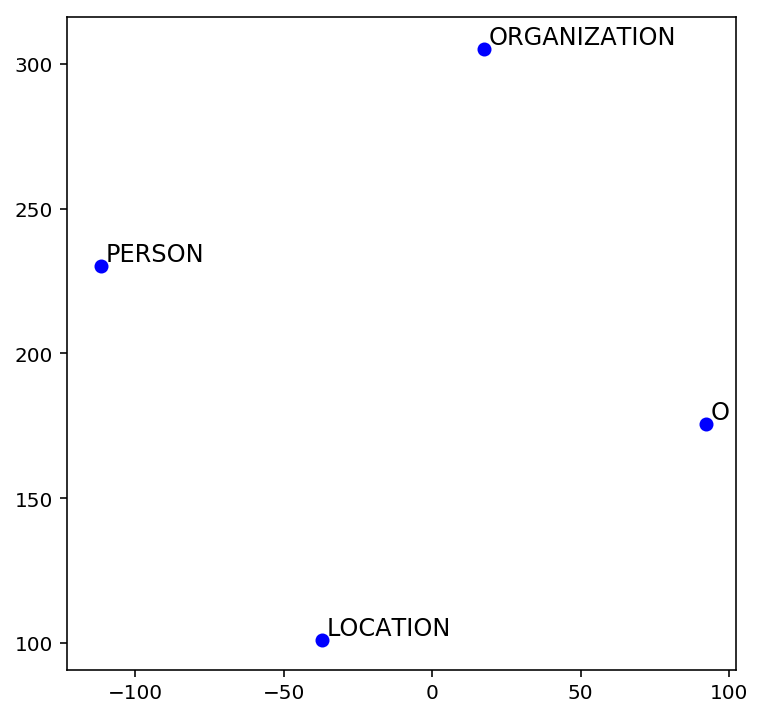

In [12]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

viz_words = n_vocab
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

fig, ax = plt.subplots(figsize=(6, 6))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='blue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=1, xytext=(embed_tsne[idx, 0]+1.5, embed_tsne[idx, 1]+1.5), fontsize=12)